## Описание проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

## Цель проекта

Построить модель машинного обучения, которая предскажет конечную температуру стали для партии, что поможет прогнозировать количество потраченной электроэнергии и материалов, а также принимать решения по изменению технологического процесса.

## Задачи проекта

В ходе достижения цели проекта будут решены следующие задачи:

    Рассмотрены исходные данные с целью ознакомления и проверка на наличие аномалий, выбросов;
    Проивзедён опрос Заказчика по уточнению целей, задач и нюансов в распознавании данных;
    Произведена предобработка данных с целью дальнейшего наилучшего подбора модели;
    Произведено объединение данных из различных таблиц;
    Произведён анализ очищенных данных, исследованы корреляции признаков;
    Разделены признаки на тренировочные и целевой (при необходимости добавлены новые признаки);
    Разделены выборки на тренировочную и тестовую;
    Произведён подбор нескольких моделей машинного обучения с перебором гиперпараметров на кросс-валидации;
    Отобрана лучшая модель на кросс-валидации по параметрам качества предсказаний (основное) и времени работы (второстепенное);
    Проверена лучшая модель на тестовой выборке;
    Составлен отчёт о проделанной работе и рекомендациях бизнесу по применению модели.
    

## Описание данных

Данные состоят из файлов, полученных из разных источников:

    data_arc_new.csv — данные об электродах;
    data_bulk_new.csv — данные о подаче сыпучих материалов (объём);
    data_bulk_time_new.csv — данные о подаче сыпучих материалов (время);
    data_gas_new.csv — данные о продувке сплава газом;
    data_temp_new.csv — результаты измерения температуры;
    data_wire_new.csv — данные о проволочных материалах (объём);
    data_wire_time_new.csv — данные о проволочных материалах (время).
    
Во всех файлах столбец key содержит номер партии. В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.

# 1. Проведение обзора данных (EDA)

## Импорт инструментов

In [1]:
import warnings #импорт инструмента для управления предупреждениями

import pandas as pd #импорт библиотеки pandas (работа с таблицами)

import matplotlib.pyplot as plt #импорт библиотеки matplotlib.pyplot (работа с графиками)
import seaborn as sns #импорт seaborn для работы с графиками: таблица корреляции

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV #импорт инструмента для разделения выборок и подбора моделей на кроссвалидации
from sklearn.ensemble import RandomForestRegressor #импорт модели случайного леса
from sklearn.linear_model import LinearRegression #импорт модели линейной регрессии
from sklearn.metrics import mean_absolute_error, make_scorer #импорт метрики MAE, инструмента для создания метрик
from sklearn.preprocessing import StandardScaler #импорт инструмента масштабирования
import lightgbm #импорт инструмента градиентного бустинга lightGBM
from lightgbm import LGBMRegressor #импорт модели регрессии на градиентном бустинге lightGBM
import catboost #импорт инструмента градиентного бустинга CatBoost
from catboost import CatBoostRegressor #импорт модели регрессии на градиентном бустинге CatBoost

## Загрузка данных

In [2]:
#пути для ревью
path_1_1='/datasets/data_arc_new.csv'
path_2_1='/datasets/data_bulk_new.csv'
path_3_1='/datasets/data_bulk_time_new.csv'
path_4_1='/datasets/data_gas_new.csv'
path_5_1='/datasets/data_temp_new.csv'
path_6_1='/datasets/data_wire_new.csv'
path_7_1='/datasets/data_wire_time_new.csv'

#пути для работы
path_1_2='data_original/data_arc_new.csv'
path_2_2='data_original/data_bulk_new.csv'
path_3_2='data_original/data_bulk_time_new.csv'
path_4_2='data_original/data_gas_new.csv'
path_5_2='data_original/data_temp_new.csv'
path_6_2='data_original/data_wire_new.csv'
path_7_2='data_original/data_wire_time_new.csv'

try:
    #данные об электродах
    data_arc_new=pd.read_csv(path_1_1)
    #данные о подаче сыпучих материалов (объём)
    data_bulk_new=pd.read_csv(path_2_1)
    #данные о подаче сыпучих материалов (время)
    data_bulk_time_new=pd.read_csv(path_3_1)
    #данные о продувке сплава газом
    data_gas_new=pd.read_csv(path_4_1)
    #результаты измерения температуры
    data_temp_new=pd.read_csv(path_5_1)
    #данные о проволочных материалах (объём)
    data_wire_new=pd.read_csv(path_6_1)
    #данные о проволочных материалах (время)
    data_wire_time_new=pd.read_csv(path_7_1)
except:
    #данные об электродах
    data_arc_new=pd.read_csv(path_1_2)
    #данные о подаче сыпучих материалов (объём)
    data_bulk_new=pd.read_csv(path_2_2)
    #данные о подаче сыпучих материалов (время)
    data_bulk_time_new=pd.read_csv(path_3_2)
    #данные о продувке сплава газом
    data_gas_new=pd.read_csv(path_4_2)
    #результаты измерения температуры
    data_temp_new=pd.read_csv(path_5_2)
    #данные о проволочных материалах (объём)
    data_wire_new=pd.read_csv(path_6_2)
    #данные о проволочных материалах (время)
    data_wire_time_new=pd.read_csv(path_7_2)


## Изучение исходных данных

В данном пункте рассмотрим исходные данные: определим общую информацию о столбцах, о представленных значениях, о выбросах, пропусках, распределениях.

### Изучение исходных данных об электродах

In [3]:
#вывод первых строк на экран методом head
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


Комментарий: как видно, таблица с данными об электродах сордежит следующие столбцы:

    key - номер партии
    Начало нагрева дугой - время начала нагрева
    Конец нагрева дугой - время окончания нагрева
    Активная мощность - видимо среднее значение активной электрической мощности, выраженная наверное в МВт (Нужно уточнить)
    Реактивная мощность - аналогичное среднее значение реактивной электрической мощности, выраженная в МВАр (Аналогично стоит уточнить)

In [4]:
#вывод информации о датасете методом info()
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Комментарий: как видно, пропусков в данной таблице нет. Однако, стоит отметить, что значения дат имеют тип object - на этапе предобработки данных надо будет привести столбец к формату datetime.

In [5]:
#вывод информации о числовых столбцах методом describe()
data_arc_new.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.662752,0.438986
std,934.571502,0.258885,5.873485
min,1.000000,0.223120,-715.479924
25%,806.000000,0.467115,0.337175
50%,1617.000000,0.599587,0.441639
75%,2429.000000,0.830070,0.608201
max,3241.000000,1.463773,1.270284


Комментарий: в глаза сразу бросилось минимальное значение реактивной мощности: -715.479924. В силу особенностей различных электрических машин значение реактивной мощности может быть отрицательным, однако значение чрезвычайно велико. Стоит предположить, что имела место ошибка ввода: часто при переводе единиц используются различные степени чисел-значений мощностей: МВАр, кВАр и ВАр, отличающиеся как раз в 1000 раз, и тогда значение было бы -0.715. Стоит это иметь в виду в дальнейшем.

В остальном значения мощностей реалистичны и лежат в определённых пределах с небольшим разбросом.

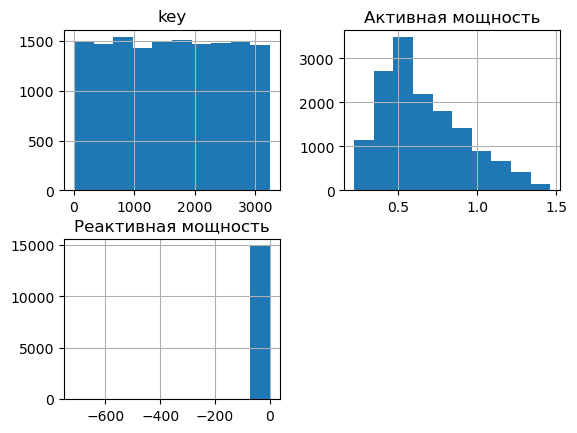

In [6]:
#построение общей гистограммы методом hist
data_arc_new.hist();

Комментарий: зависимость по распределению чисел для столбца key неинформативна (малое число корзин), как и для реактивной мощности (тут есть выбросы). По распределению величин значений по столбцу Активная мощность можно сказать, что данное распределение похоже на нормальное, с медианой в районе 0.6, что похоже на информацию вызванную методом describe.

**Общий вывод по исходным данным по электродам**

    Содержат информацю о времени работы электродов и электрические параметры, характерные для определённых временных промежутков;
    Типы данных - стоит скорректировать по столбцам с временами;
    Пропуски - отсуствуют;
    Выбросы - присутствуют в столбце Реактивная мощность (возможно ошибка размерности)
    
Вопросы для Заказчика:

    Активная и реактивная мощность - размерность и правда ли, что это среднее значение для указанного временного промежутка. Зачем нужно - для осознания масштаба величин, насколько это потом влияет на экономику (если величины представлены в кВт, кВАр - эффект экономический один, если же в МВт и МВАр, то совершенно иной - в 1000 раз значительней);
    Также интересно, какая мощность нужна: активная, реактивная или же обе (полная)? В зависимости от договора с сетевой организацией в оплате реактивной мощности могут быть нюансы: она может не оплачиваться, оплачиваться по сниженной ставке и тд. 
    
    

 
Какой фактор использовать в модели - дело как раз аналитика) Может полная, может отношение мощностей ... будет точнее для моделирования. Тут дело на исследование как раз. При моделировании не смотрим на то, как оплачивается мощность. Нам надо найти зависимость между целевой и факторами производства и начальным состоянием объекта моделирования.<br>
По размерности: пользуемся сейчас теми данными что есть. По каждой итерации - это мощность потраченная на данную итерацию По числам - возможно, что в данных есть искажающий, но сохраняющий динамику коэффициент. 

### Изучение исходных данных о подаче сыпучих материалов (объём)

In [7]:
#вывод первых строк на экран методом head
data_bulk_new.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
5,6,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,201.0,154.0
6,7,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,152.0,154.0
7,8,NaN,NaN,NaN,99.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,410.0,NaN,252.0,153.0
8,9,NaN,NaN,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107.0,NaN,99.0,203.0
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,102.0,204.0


Комментарий: как видно, таблица с данными о подаче сыпучих материалов сордежит следующие столбцы:

    key - номер партии;
    Bulk 1, Bulk 2 ... Bulk 15 - видимо, значения объёмов различных добавляемых веществ (вещество 1...вещество 15) - нужно уточнить у Заказчика - так ли это?
   
Стоит отметить, что для различных партий различный состав добавляемых веществ: для некоторых партий часть веществ вовсе не добавляется, тогда как значения добавляемых же веществ разнятся от партии к партии.

In [8]:
#вывод информации о датасете методом info()
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


Комментарий: как видно, в таблице присутствуют пропуски, но они могут быть вполне объяснимы технологическим процессом.

По типам данных вопросов нет, всё логично.

In [9]:
#вывод информации о числовых столбцах методом describe()
data_bulk_new.describe()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


Комментарий: интересный момент со стобцом key: значений - 3129, а вот максимальное число - 3241. Видимо, некоторое количество партий упущено, не попало в датасет. По какой причине - неясно, возможно, что для этих партий вовсе не производилось добавление сыпучих материалов. 

Стоит отметить максимальное значение в столбце Bulk 12: 1849 против медианного значения  208. Разница порядка в 9 раз - возможно, выброс. В остальных случаях такого не наблюдается. Стоит уточнить у Заказчика. 

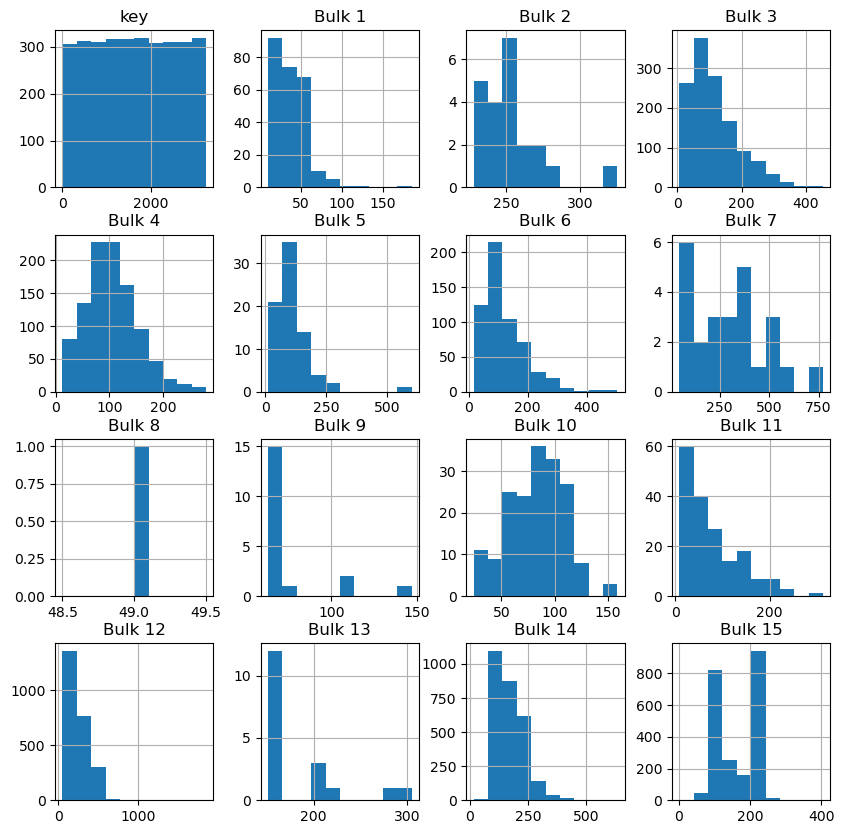

In [10]:
#построение общей гистограммы методом hist
data_bulk_new.hist(figsize=(10,10));

Комментарий: зависимость по распределению чисел для столбца key неинформативна (малое число корзин). Далее стоит отметить, что для материалов с номерами 3, 4, 5, 6, 10, 14 распределение величин похоже на нормальное. В остальных случаях зависимость более специфичная.

**Общий вывод по исходным данным по объёмам добавляемых сыпучих веществ**

    Содержат информацю об объёмах добавления различных веществ в зависимости от партии. Некоторые вещества добавляются очень часто, некоторые - очень редко;
    Возможно, присутствуют выбросы в столбце Bulk 12;
    Отсутствуют данные по некоторым партиям - возможно ли, что в них не добавлялось сыпучих веществ?
    
Вопросы для Заказчика:

    Реалистично ли максимальное значение Bulk 12 в 1849, что отличается от медианы в 9 раз? Зачем нужно - понять выброс это или нет для дальнейшей корректной работы модели машинного обучения;
    Возможно ли, что в некоторых партиях не производилось добавление сыпучих веществ? Зачем нужно - понять присутствуют ли пропуски в данных по некоторым партиям или это особенность технологического процесса?
    
    

### Изучение исходных данных о подаче сыпучих материалов (время)

In [11]:
#вывод первых строк на экран методом head
data_bulk_time_new.head(15)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,NaN,NaN,NaN,2019-05-03 13:57:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:48:52,NaN,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,NaN,NaN,NaN,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 14:41:26,NaN,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 15:17:58,NaN,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:03:08,NaN,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 16:38:11,NaN,2019-05-03 16:34:24,2019-05-03 16:29:56


Комментарий: как видно, таблица с данными о подаче сыпучих материалов сордежит следующие столбцы:

    key - номер партии;
    Bulk 1, Bulk 2 ... Bulk 15 - время добавления различных веществ (вещество 1...вещество 15)
   
Стоит отметить, что для различных партий различный состав добавляемых веществ: указано время для реально добавляемых веществ, тогда как в остальных случаях - пропуски.

In [12]:
#вывод информации о датасете методом info()
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Комментарий: как видно, аналогично предыдущему, в таблице присутствуют пропуски, но они могут быть вполне объяснимы технологическим процессом.

Тип данных - object, нужно будет заменить на datetime.

In [13]:
#вывод информации о числовых столбцах методом describe()
data_bulk_time_new.describe()

,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


Комментарий: аналогично таблице с данными о сыпучих веществах: количество key - 3129, а максимум - 3241. 

Гистограммы распределений для данной таблицы строить бессмысленно.

**Общий вывод по исходным данным по времени добавления сыпучих веществ**

    Содержат информацю о временеи добавления различных веществ в сплав;
    Данные коррелируют с информацией из таблицы с объёмами добавляемых веществ.


### Изучение исходных данных о продувке сплава газом

In [14]:
#вывод первых строк на экран методом head
data_gas_new.head(15)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


Комментарий: как видно, таблица с данными об электродах сордежит следующие столбцы:

    key - номер партии
    Газ 1 - возможно, количество газа, используемого для продувки сплава. Стоит уточнить у Заказчика.

In [15]:
#вывод информации о датасете методом info()
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


Комментарий: как видно, пропусков в данной таблице нет. Однако стоит отметить, что число строк - 3239, тогда как число строк для таблицы с сыпучими материалами составило 3129. Стоит иметь это в виду на будущее: пока непонятно, какое число и какие конкретно партии отображены в различных таблицах.

In [16]:
#вывод информации о числовых столбцах методом describe()
data_gas_new.describe()

,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


Комментарий: по значениям явных выбросов не замечено. Возможно, минимальное значение 0.008 слишком небольшое относительно медианы, однако, это может быть обусловлено и технологическим процессом.

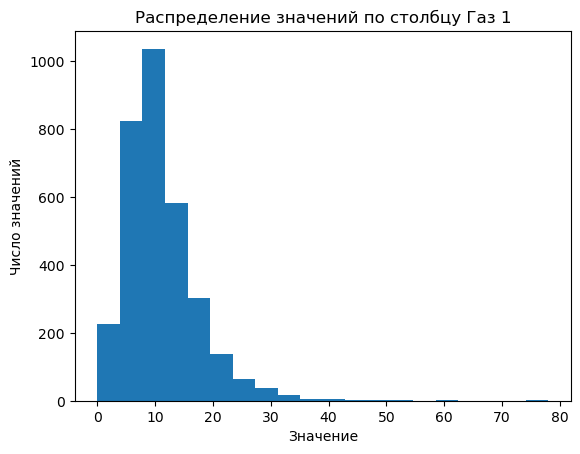

In [17]:
#построение гистограммы 
plt.hist(data_gas_new['Газ 1'], bins=20)
plt.title('Распределение значений по столбцу Газ 1')
plt.xlabel('Значение')
plt.ylabel('Число значений')
plt.show()

Комментарий: как видно, распределение значений по столбцу Газ 1 похоже на нормальное, однако есть выделяющиеся значения в районе 60 и 76. Построим диаграмму "ящика с усами":

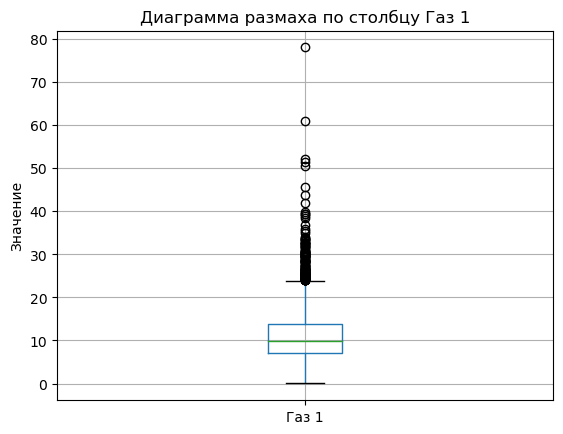

In [18]:
data_gas_new.boxplot('Газ 1')
plt.title('Диаграмма размаха по столбцу Газ 1')
plt.ylabel('Значение')
plt.show()

Комментарий: как видно, для значений выше верхнего уса присутствуют множество единичных данных. Стоит уточнить у Заказчика, реалистичен ли максимум согласно технологическому процессу или же можно определить реалистичную границу выбросов.

**Общий вывод по исходным данным по информации продувки газом**

    Содержат информацю о количестве добавленного газа в сплав.
    
Вопросы для Заказчика:

    Правда ли информация - это количество добавленного газа? (А вдруг давление например и тогда логика рассуждений будет немного иной?);
    Реалистичны ли для столбца значения в 77,99 и 0.008? Не являются ли они выбросами? 

### Изучение исходных данных о температурах сплава

In [19]:
#вывод первых строк на экран методом head
data_temp_new.head(15)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


Комментарий: как видно, таблица с данными об электродах сордежит следующие столбцы:

    key - номер партии,
    Время замера - непосредственно время замера температуры,
    Температура - значение температуры. Похоже, что в градусах Цельсия.

In [20]:
#вывод информации о датасете методом info()
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


Комментарий: как видно, в данной таблице присутствует значительное количество пропусков по столбцу Температуры. 

Также тип данных в столбце Время замера надо перевести из object в datetime.

In [21]:
#вывод информации о числовых столбцах методом describe()
data_temp_new.describe()

,key,Температура
count,18092.000000,14665.000000
mean,1616.460977,1590.722741
std,934.641385,20.394381
min,1.000000,1191.000000
25%,807.750000,1580.000000
50%,1618.000000,1590.000000
75%,2429.000000,1599.000000
max,3241.000000,1705.000000


Комментарий: есть ощущение, что значения реалистичны. Стоит только отметить, что минимальное значение в 1191 градус Цельсия не соответствует минимальной температуре расплава стали (в районе 1350 градусов Цельсия), однако, возможно это и нормально для нашей установке: что мы имеем данные о температурах не только расплава, но и до него, а также возможны изменения физикохимических свойств металла при легировании.

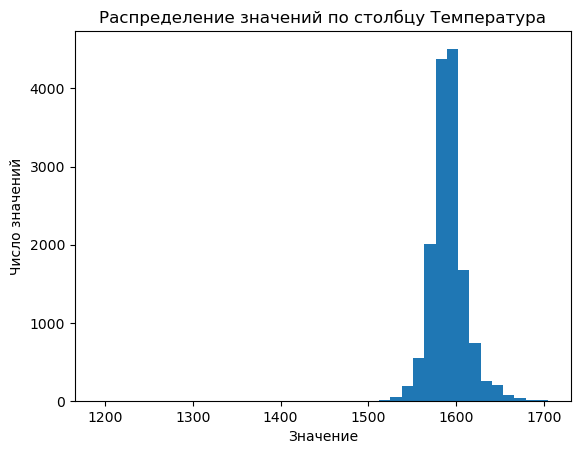

In [22]:
#построение гистограммы для столбца

plt.hist(data_temp_new['Температура'], bins=40)
plt.title('Распределение значений по столбцу Температура')
plt.xlabel('Значение')
plt.ylabel('Число значений')
plt.show()

Комментарий: распределение похоже на нормальное. И как раз-таки значение в 1191 явлется подозрительным. Построим диаграмму размаха:

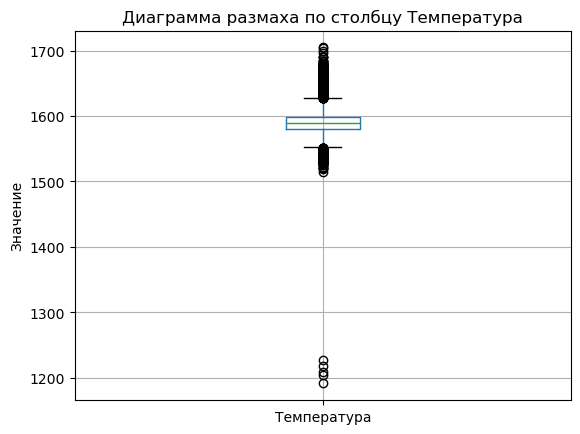

In [23]:
data_temp_new.boxplot('Температура')
plt.title('Диаграмма размаха по столбцу Температура')
plt.ylabel('Значение')
plt.show()

Комментарий: как видно, присутствуют единичные значения температур в районе 1200-1250 градусов Цельсия. Похоже, что всё-таки это выброс.

**Общий вывод по исходным данным по температурам**

    Содержат информацю о партии, времени замера температуры и значения температур.
    Типы данных - стоит скорректировать по столбцам с временами;
    Пропуски - присутствует, значительное количество;
    Выбросы - пристствуют в значениях температуры - в районе 1200-1250 градусов Цельсия.
    
Вопросы для Заказчика:

    Просьба пояснить, являются ли значения в 1200-1250 выбросами?
    Также есть вопрос по пропускам: есть ли возможность получить датасет без них? Если нет, то каким образом целесообразно их заполнять или же не стоит этого делать и лучше удалить их? (Но стоит иметь в виду, что количество пропусков значительно: порядка 4000 строк или 20-25% датасета)
    
    

### Изучение исходных данных о проволочных материалах (объём)

In [24]:
#вывод первых строк на экран методом head
data_wire_new.head(15)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,99.109917,9.114560,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,98.061600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,155.282394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,113.393279,9.143681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,81.244796,12.376000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Комментарий: как видно, таблица с данными об электродах сордежит следующие столбцы:

    key - номер партии
    Wire 1...Wire 9 - количество различных материалов
    
Во многих столбцах отсутствуют значения: возможно, в данном случае не производилось добавление определённых веществ.

In [25]:
#вывод информации о датасете методом info()
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


Комментарий: аналогично и сыпучим материалам: прпоуски есть, скорее всего - это норма. Типы данных соответствуют реальности.

In [26]:
#вывод информации о числовых столбцах методом describe()
data_wire_new.describe()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


Комментарий: есть предположение, что цифры не содержат в себе явных аномалий.

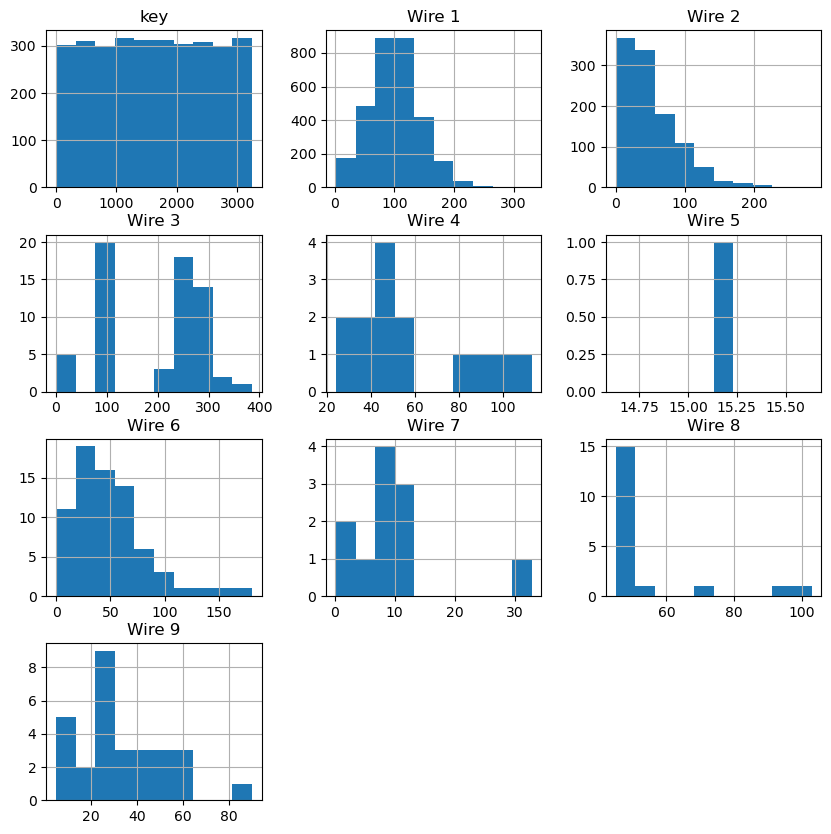

In [27]:
#построение общей гистограммы методом hist
data_wire_new.hist(figsize=(10,10));

Комментарий: стоит отметить, что для материалов номер 1,6 и в меньшей степени 5 можно наблюдать нормальное распределение. В остальных же случаях распределения значений носят исключительные характеры.

**Общий вывод по исходным данным по проволочным материалам**

    Содержат информацю об объёмах добавления различных веществ в зависимости от партии. Некоторые вещества добавляются очень часто, некоторые - очень редко;
    Явных выбросов не наблюдается

### Изучение исходных данных о подаче проволочных материалов (время)

In [28]:
#вывод первых строк на экран методом head
data_wire_time_new.head(15)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:11:46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,2019-05-03 14:18:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,2019-05-03 15:01:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Комментарий: как видно, таблица с данными о подаче сыпучих материалов сордежит следующие столбцы:

    key - номер партии;
    Wire 1...Wire 9 - время добавления различных веществ (вещество 1...вещество 9)
   
Стоит отметить, что для различных партий различный состав добавляемых веществ: указано время для реально добавляемых веществ, тогда как в остальных случаях - пропуски.

In [29]:
#вывод информации о датасете методом info()
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Комментарий: как видно, аналогично предыдущему, в таблице присутствуют пропуски, но они могут быть вполне объяснимы технологическим процессом.

Тип данных - object, нужно будет заменить на datetime.

In [30]:
#вывод информации о числовых столбцах методом describe()
data_wire_time_new.describe()

,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


Комментарий: аналогично таблице с данными о сыпучих веществах: количество key - 3089, а максимум - 3241. 

Гистограммы распределений для данной таблицы строить бессмысленно.

**Общий вывод по исходным данным по времени добавления проволочных веществ**

    Содержат информацю о временеи добавления различных веществ в сплав;
    Данные коррелируют с информацией из таблицы с объёмами добавляемых веществ.


## Список уточняющих вопросов

Основные вопросы:
    
    Цель исследования состоит в том чтобы предсказать конечную температуру обработки сплава, при которой будет наименьший расход электроэнергии?
    Какая метрика ошибки модели будет целевой и какого её значение?

Вопросы по датасету о потреблении электроэнергии:

    Активная и реактивная мощность - размерность и правда ли, что это среднее значение для указанного временного промежутка. Зачем нужно - для осознания масштаба величин, насколько это потом влияет на экономику (если величины представлены в кВт, кВАр - эффект экономический один, если же в МВт и МВАр, то совершенно иной - в 1000 раз значительней);
    Также интересно, какая мощность нужна: активная, реактивная или же обе (полная)? В зависимости от договора с сетевой организацией в оплате реактивной мощности могут быть нюансы: она может не оплачиваться, оплачиваться по сниженной ставке и тд. 
    
Вопросы по датасетам с сыпучими веществами:

    Реалистично ли максимальное значение Bulk 12 в 1849, что отличается от медианы в 9 раз? Зачем нужно - понять выброс это или нет для дальнейшей корректной работы модели машинного обучения;
    Возможно ли, что в некоторых партиях не производилось добавление сыпучих веществ? Зачем нужно - понять присутствуют ли пропуски в данных по некоторым партиям или это особенность технологического процесса?
    
Вопросы по датасету о продувке газом:

    Правда ли информация - это количество добавленного газа? (А вдруг давление например и тогда логика рассуждений будет немного иной?);
    Реалистичны ли для столбца значения в 77,99 и 0.008? Не являются ли они выбросами? 
    
Вопросы по датасету о температурах:

    Просьба пояснить, являются ли значения в 1200-1250 градусов выбросами?
    Также есть вопрос по пропускам: есть ли возможность получить датасет без них? Если нет, то каким образом целесообразно их заполнять или же не стоит этого делать и лучше удалить их? (Но стоит иметь в виду, что количество пропусков значительно: порядка 4000 строк или 20-25% датасета)

## Выводы

На основе обзора исходных данных и ответа Заказчика по вопросам, сделаны следующие выводы:

* Представленные данные характеризуют процесс выплавки и легирования стали
* В данных присутствует незначительное число выбросов:
    
    По согласованию с Заказчиком решено удалить строки со значениями температур менее 1400 градусов Цельсия;
    Также решено удалить строку с аномальным значением реактивной мощности

* В данных присутствуют пропуски:
    
    Для таблиц с объёмами и временем добавления материалов принято заменить пропуски на 0:
    Для таблицы с отстутствующими значениями температур эти данные решено не учитывать в исследовании

* Во всех таблицах, где встречаются значения даты и времени необходимо изменить тип данных с object на datetime
* Распределения значений по всем данным носят как нормальный характер, так и отличающиеся от нормального виды. Однако явных аномалий крайне мало

## Примерный план решения задачи

В ходе достижения цели проекта будут решены следующие задачи:

    Рассмотрены исходные данные с целью ознакомления и проверка на наличие аномалий, выбросов;
    Проивзедён опрос Заказчика по уточнению целей, задач и нюансов в распознавании данных;
    Произведена предобработка данных с целью дальнейшего наилучшего подбора модели:
        Удалены выбросы;
        Обработаны пропуски (для добавляемых веществ объёмы - нули, для времени - заглушки, что делать с пропусками по температурам - пока вопрос);
        
    Произведено объединение данных из различных таблиц;
    Произведён анализ очищенных данных, исследованы корреляции признаков;
    Разделены признаки на тренировочные и целевой (при необходимости добавлены новые признаки);
    Разделены выборки на тренировочную и тестовую;
    Произведён подбор нескольких моделей машинного обучения с перебором гиперпараметров на кросс-валидации;
    Отобрана лучшая модель на кросс-валидации по параметрам качества предсказаний (основное) и времени работы (второстепенное);
    Проверена лучшая модель на тестовой выборке;
    Составлен отчёт о проделанной работе и рекомендациях бизнесу по применению модели.

На основе примерного плана решения составлен окончательный план проекта:

## План проекта
**1. Проведение обзора данных (EDA)**

**Подготовка и анализ исходных данных:** 
* Импорт необходимых библиотек;
* Загрузка данных;
* Получение общей информации о таблицах (head, info, describe);
* Корректировка наименований столбцов (при необходимости);
* Графическое представление данных из таблиц;
* Проверка данных на аномалии.
* Выводы

**Предобработка данных:**
* Корректировка типов данных (при необходимости);
* Заполнение пропусков;
* Удаление дубликатов (при наличии);
* Удаление выбросов;
* Выделение признаков и таргета;
* Соединение таблиц.
* Выводы

**Исследование итоговой таблицы с данными:**
* Аналитический анализ
* Графический анализ
* Корреляционный анализ
* Выводы

**2. Построение модели машинного обучения**

**Обучение модели:**
* Разделение данных на обучающую и тестовую выборки;
* Масштабирование данных;
* Обучение модели линейной регрессии;
* Обучение модели случайного леса;
* Обучение модели градиентного бустинга lightgbm;
* Обучение модели градиентного бустинга catboost;
* Константная модель;
* Выбор лучшей модели

**Проверка моделей:**
* Тестирование лучшей модели на тестовой выборке;
* Если MAE на тестовых данных > 6.8 - доработка модели.
* Анализ важности факторов

**3. Общий вывод**

## Предобработка данных

### Корректировка типов данных

Типы данных, которые нужно скорректировать - даты в таблицах data_arc_new, data_bulk_time_new,data_temp_new, data_wire_time_new

Сначала выводим методом info() типы данных по столбцам, затем заменяем типы данных методом to_datetime, затем проверяем изменения. 

Таблица **data_arc_new**

In [31]:
#выведем названия столбцов с object для таблицы data_arc_new
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [32]:
#замена типа данных методом to_datetime для столбцов Начало нагрева дугой, Конец нагрева дугой
data_arc_new['Начало нагрева дугой']=pd.to_datetime(data_arc_new['Начало нагрева дугой'])
data_arc_new['Конец нагрева дугой']=pd.to_datetime(data_arc_new['Конец нагрева дугой'])

In [33]:
#проверка изменений
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


Таблица **data_bulk_time_new**

In [34]:
#выведем названия столбцов с object для таблицы 
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [35]:
#замена в столбцах с номерами 1:15
data_bulk_time_new[data_bulk_time_new.columns[1:16]]= \
data_bulk_time_new[data_bulk_time_new.columns[1:16]] \
.apply(pd.to_datetime)

In [36]:
#проверка изменений
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


Таблица **data_temp_new**

In [37]:
#выведем названия столбцов с object для таблицы 
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [38]:
#замена типа данных методом to_datetime для столбца Время замера
data_temp_new['Время замера']=pd.to_datetime(data_temp_new['Время замера'])

In [39]:
#проверка изменений
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


Таблица **data_wire_time_new**

In [40]:
#выведем названия столбцов с object для таблицы 
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [41]:
#замена в столбцах с номерами 1:9
data_wire_time_new[data_wire_time_new.columns[1:10]]= \
data_wire_time_new[data_wire_time_new.columns[1:10]] \
.apply(pd.to_datetime)

In [42]:
#проверка изменений
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


### Обработка пропусков

Таблицы, в которых присутствуют пропуски: 
    
    data_bulk_new - не добавленные материалы, NaN заменяем на 0
    data_bulk_time_new - аналогично
    data_temp_new - так как конечная температура является целевым признаком, то заполнять пропуски не имеет смысла, эти строки придётся удалить
    data_wire_new - не добавленные материалы, NaN заменяем на 0
    data_wire_time_new - аналогично

**Заполнение пропусков в таблицах с материалами**

In [43]:
#заполнение пропусков методом fillna
data_bulk_new=data_bulk_new.fillna(0)
data_bulk_time_new=data_bulk_time_new.fillna(0)
data_wire_new=data_wire_new.fillna(0)
data_wire_time_new=data_wire_time_new.fillna(0)

#проверка для одного из датасетов методом head()
data_bulk_new.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


**Удаление пропусков в таблице с температурами**

In [44]:
#удаление пропусков в таблице методом dropna()
data_temp_new=data_temp_new.dropna()

In [45]:
#проверка удаления пропусков методом info()
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14665 entries, 0 to 18086
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           14665 non-null  int64         
 1   Время замера  14665 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 458.3 KB


### Удаление дубликатов

Проверим данные на наличие явных дубликатов.

In [46]:
#создадим список с датасетами
df_full=[data_arc_new,data_bulk_new,data_bulk_time_new,data_gas_new,data_temp_new,data_wire_new,data_wire_time_new]

#вызовем метод duplicated ко всем датасетам и просуммируем число дубликатов при наличии
for i in df_full:
    print(i.duplicated().sum())


0
0
0
0
0
0
0


Как видно, явных дубликатов не нашлось. Неявных дубликатов при рассмотрении исходных данных не наблюдалось.

### Удаление выбросов

По согласованию с Заказчиком решено удалить строки со значениями температур менее 1400 градусов Цельсия в таблице data_temp_new;

Также решено удалить строку с аномальным значением реактивной мощности в таблице data_arc_new

In [47]:
#удаление строк с низким значением температуры
data_temp_new=data_temp_new[data_temp_new['Температура']>=1400]

#проверка удаления
data_temp_new['Температура'].min()

1515.0

In [48]:
#удаление отрицательных значений Реактивной мощности
data_arc_new=data_arc_new[data_arc_new['Реактивная мощность']>0]

#проверка удаления
data_arc_new['Реактивная мощность'].min()

0.153777

### Выделение признаков и таргета

Исходя из логики производственного процесса, металл в расплавленном состоянии в ковше находится, нагревается, насыщается добавками и перемешивается газом столько времени, сколько нужно для получения металла определённого качества на выходе. При этом чем хуже сырьё или чем больше неоптимальных действий совершается по пути, тем дольше металл находится в ковше, проходит больше итераций нагрева-добавок-размешивания, и тем сильнее он нагревается.

Таким образом, таргетом является окончательная температура нагрева сплава.

В качестве признаков можно утверждать следующее:

    В отношении потребляемой электроэнергии по идее надо использовать полную мощность, которую потребляет установка в силу возможных особенностей электрической нагревательной установки. Поэтому добавим новый признак - полная электрическая мощность, равная корню квадратному из сумм квадратов активной и реактивной составляющей мощностей;
    Также есть смысл посчитать отдельно длительность времени нагрева;
    Присадки есть популярные, которые добавляются в первую очередь, и в больших количествах, а также непопулярные, объёмы которых в сотни раз меньше чем у основных. Однако, пока что, есть смысл оставить признаки по материалам как есть: возможно, что некоторые присадки несмотря на небольшое своё количество существенно влияют на процесс обработки металла. Если же модель будет работать недостаточно хорошо, то можно будет вернуться к этому вопросу;
    А вот время добавления присадок особенно с учётом разности в количестве присадок, а также с данными по партии суммано (а не по итерациям) кажется излишней информацией. Поэтому не будем объединять данные из таблиц со временем добавления материалов;
    data_temp_new - отберём только начальную и конечную температуры для каждой партии. При этом партии, где только одна температура, будут удалены (у них нет фактически конечной температуры), а также добавим новый признак - длительность времени измерений (не нагрева).
    

**Добавление признака полной электрической мощности**

In [49]:
#модификация оповещений pandas о предупреждении коллизий при копировании данных
pd.options.mode.chained_assignment=None
#добавление столбца "полная мощность" 
data_arc_new['Полная мощность'] = (data_arc_new['Активная мощность'] ** 2 + data_arc_new['Реактивная мощность'] ** 2) ** 0.5

**Добавление признака длительности нагрева**

In [50]:
#расчёт разницы между началом и концом нагрева
data_arc_new['Длительность нагрева']=data_arc_new['Конец нагрева дугой']-data_arc_new['Начало нагрева дугой']
#перевод значений в секунды
data_arc_new['Длительность нагрева']=data_arc_new['Длительность нагрева'].dt.seconds

**Добавление признака длительности измерений**

In [51]:
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18061,3237,2019-09-06 11:31:15,1569.0
18067,3238,2019-09-06 12:16:15,1584.0
18071,3239,2019-09-06 14:16:50,1598.0
18080,3240,2019-09-06 15:25:21,1617.0


In [52]:
data_temp_new_temp=data_temp_new.groupby('key')['Температура'].agg(['first','last','count'])

In [53]:
data_temp_new_time=data_temp_new.groupby('key')['Время замера'].agg(['first','last','count'])

In [54]:
data_temp_new_time

,first,last,count
key,,,
1,2019-05-03 11:02:04,2019-05-03 11:30:38,6
2,2019-05-03 11:34:04,2019-05-03 11:55:09,5
3,2019-05-03 12:06:44,2019-05-03 12:35:57,6
4,2019-05-03 12:39:27,2019-05-03 12:59:47,5
5,2019-05-03 13:11:03,2019-05-03 13:36:39,5
...,...,...,...
3237,2019-09-06 11:31:15,2019-09-06 11:31:15,1
3238,2019-09-06 12:16:15,2019-09-06 12:16:15,1
3239,2019-09-06 14:16:50,2019-09-06 14:16:50,1


In [55]:
data_temp_new_time['Длительность между замерами']=(data_temp_new_time['last']-data_temp_new_time['first']).dt.seconds

In [56]:
data_temp_new_time=data_temp_new_time.drop(columns=['count','first','last'])

In [57]:
data_temp_new_time

,Длительность между замерами
key,
1,1714
2,1265
3,1753
4,1220
5,1536
...,...
3237,0
3238,0
3239,0


In [58]:
#объединяем в итоговый датасет data_temp_new снова
data_temp_new=data_temp_new_temp.join(data_temp_new_time,how='inner',on='key')

In [59]:
#переименование столбцов first, last 
data_temp_new=data_temp_new.rename(columns={'first':'Начальная температура','last':'Конечная температура'})

In [60]:
#удаление строк с одним значением температуры
data_temp_new=data_temp_new[data_temp_new['count']>1]

In [61]:
#выводим начало 
data_temp_new.head()

,Начальная температура,Конечная температура,count,Длительность между замерами
key,,,,
1,1571.0,1613.0,6,1714
2,1581.0,1602.0,5,1265
3,1596.0,1599.0,6,1753
4,1601.0,1625.0,5,1220
5,1576.0,1602.0,5,1536


In [62]:
#удаляем колонку с количеством замеров
data_temp_new=data_temp_new.drop(columns=['count'])

In [63]:
#вывод на экран части обновленного датасета
data_temp_new.tail()

,Начальная температура,Конечная температура,Длительность между замерами
key,,,
2495,1570.0,1591.0,1380
2496,1554.0,1591.0,1705
2497,1571.0,1589.0,962
2498,1591.0,1594.0,1520
2499,1569.0,1603.0,1537


In [64]:
data_temp_new

,Начальная температура,Конечная температура,Длительность между замерами
key,,,
1,1571.0,1613.0,1714
2,1581.0,1602.0,1265
3,1596.0,1599.0,1753
4,1601.0,1625.0,1220
5,1576.0,1602.0,1536
...,...,...,...
2495,1570.0,1591.0,1380
2496,1554.0,1591.0,1705
2497,1571.0,1589.0,962


### Соединение таблиц

Для полного анализа необходимо объединить все таблицы, за искюлчением таблиц с временами подачи сыпучих и проволочных материалов, так как они неинформативны для обучения модели по нашей логике. Таблицы можно объединить одним способом: по номеру партии. Однако, в некоторых таблицах присутствует несколько строк по каждой партии, отображая итерации процесса. Необходимо сначала агрегировать эти данные, а затем уже объединять нужные датасеты методом inner join по ключу - номеру партии key.

Датасеты, подлежащие агрегации:
    
    data_arc_new - будем суммировать потреблённые мощности по партиям;
    data_temp_new - аналогичная группировка совершена в предыдущем пункте при добавлении признаков

**Группировка data_arc_new**

In [65]:
data_arc_new.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148


In [66]:
#группировка данных таблицы data_arc_new
#стоит отметить, что время начала и конца будут удалены тк не являются числовыми столбцами
#при этом эти данные нам не нужны, тк уже посчитана Длительность нагрева
data_arc_new=data_arc_new.groupby('key')[['Активная мощность','Реактивная мощность','Полная мощность','Длительность нагрева']].sum()

#вывод на экран части сгруппированной таблицы 
data_arc_new.head()

,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева
key,,,,
1,3.036730,2.142821,3.718736,1098
2,2.139408,1.453357,2.588349,811
3,4.063641,2.937457,5.019223,655
4,2.706489,2.056992,3.400038,741
5,2.252950,1.687991,2.816980,869


**Соединение таблиц**

In [67]:
#объединение таблиц методом join (inner) по ключу key 
#для этого нужно дополнительно указать set_index для data_bulk_new, тк там есть свой индекс, отличный от key
df_full=data_arc_new.join(data_bulk_new.set_index('key'),on='key',how='inner')

In [68]:
#аналогичным образом присоединяем data_gas_new
df_full=df_full.join(data_gas_new.set_index('key'),on='key',how='inner')

In [69]:
#присоединяем data_temp_new. Теперь set_index не надо указывать - индекс key и там и там
df_full=df_full.join(data_temp_new,on='key',how='inner')

In [70]:
#присоединяем data_wire_new с указанием индекса
df_full=df_full.join(data_wire_new.set_index('key'),on='key',how='inner')

### Выводы

В соответствии с определением таргета как конечной температуры и признаков всех остальных данных, за исключением времён итераций (длительность нагрева занесена как отдельный признак, как и полная мощность) и времён добавления материалов, были произведены корректировки датасетов (предобработка, агрегация) с последующим объединением в единый датасет df_full, очищенный от выбросов и пропусков.

## Исследование итоговой таблицы с данными

### Аналитический анализ


Проанализируем теперь уже скорректированные и объединённые данные

In [71]:
#конфигурация системного параметра pandas для отображения всех столбцов датасета
pd.set_option('display.max_columns', None)

#вывод начальной части полной таблицы
df_full.head(10)

,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Начальная температура,Конечная температура,Длительность между замерами,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,3.036730,2.142821,3.718736,1098,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0,1714,60.059998,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.139408,1.453357,2.588349,811,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0,1265,96.052315,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.063641,2.937457,5.019223,655,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0,1753,91.160157,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.706489,2.056992,3.400038,741,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0,1220,89.063515,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.252950,1.687991,2.816980,869,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0,1536,89.238236,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2.725274,1.881313,3.313074,952,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,201.0,154.0,11.273392,1543.0,1596.0,1497,99.109917,9.114560,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2.626877,1.960419,3.283913,673,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,204.0,0.0,152.0,154.0,9.836267,1586.0,1599.0,1744,98.061600,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.678958,2.096952,3.405956,913,0.0,0.0,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,410.0,0.0,252.0,153.0,15.171553,1577.0,1598.0,1615,155.282394,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,3.520820,2.527365,4.335261,625,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,107.0,0.0,99.0,203.0,8.216623,1587.0,1592.0,1811,113.393279,9.143681,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Комментарий: как видно, получена итоговая объединённая таблица со следующими столбцами:

*    key - номер партии,
*    Активная, Реактивная, Полная мощности - электрические параметры потребления электроэнергии установкой;
*    Длительность нагрева - общее время нагрева для всех итераций по каждой партии, с;
*    Bulk 1... Bulk 15 - данные о подаче сыпучих материалов (объём);
*    Газ 1 - данные о продувке сплава газом;
*    Начальная и конечная температуры - температуры с начала нагрева и теммпературы на время последней итерации перед получением итогового сплава, агрегация по партиям;
*    Wire 1... Wire 15 - данные о проволочных материалах (объём).

In [72]:
#вывод информации о датасете методом info()
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2329 entries, 1 to 2499
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Активная мощность            2329 non-null   float64
 1   Реактивная мощность          2329 non-null   float64
 2   Полная мощность              2329 non-null   float64
 3   Длительность нагрева         2329 non-null   int64  
 4   Bulk 1                       2329 non-null   float64
 5   Bulk 2                       2329 non-null   float64
 6   Bulk 3                       2329 non-null   float64
 7   Bulk 4                       2329 non-null   float64
 8   Bulk 5                       2329 non-null   float64
 9   Bulk 6                       2329 non-null   float64
 10  Bulk 7                       2329 non-null   float64
 11  Bulk 8                       2329 non-null   float64
 12  Bulk 9                       2329 non-null   float64
 13  Bulk 10           

Комментарий: как видно, в итоговой таблице удалены все пропуски, подозрительные типы данных также не бросаются в глаза.

Итоговая таблица содержит 3021 строку с информацией о партиях, о которых мы имеем полное представление в части всех параметров.

In [73]:
#вывод информации о числовых столбцах методом describe()
df_full.describe()

,Активная мощность,Реактивная мощность,Полная мощность,Длительность нагрева,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Газ 1,Начальная температура,Конечная температура,Длительность между замерами,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.000000,2329.0,2329.000000,2329.000000,2329.000000,2329.000000
mean,3.125033,2.300522,3.884654,807.600687,3.427651,1.422499,47.348218,37.303564,2.640189,22.430228,2.004723,0.021039,0.444826,5.052812,4.245170,208.415629,1.067411,153.853585,119.952769,11.375600,1587.386003,1593.365393,2321.810219,102.443601,17.609859,3.234916,0.306550,0.0,0.978820,0.006361,0.311311,0.317113
std,1.221007,0.903968,1.518157,340.897332,12.412132,19.082119,75.310430,58.643238,22.402293,55.790873,30.676234,1.015340,6.220641,20.917800,22.515487,157.062272,14.235055,81.404354,84.640443,6.392041,23.619841,11.200915,1385.191527,43.539993,33.624771,27.942871,4.757746,0.0,8.693299,0.205705,4.402707,3.456561
min,0.267676,0.196228,0.331897,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008399,1519.000000,1541.000000,270.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
25%,2.293900,1.669572,2.843058,581.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,105.000000,0.000000,7.282948,1571.000000,1587.000000,1579.000000,73.207679,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
50%,3.035365,2.225398,3.767499,778.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,149.000000,107.000000,10.100950,1587.000000,1593.000000,2045.000000,101.119201,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
75%,3.834300,2.829159,4.769421,993.000000,0.000000,0.000000,80.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.000000,0.000000,204.000000,204.000000,14.216688,1603.000000,1598.000000,2791.000000,128.091599,23.102560,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
max,12.375636,8.949049,15.288271,4189.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000,77.995040,1660.000000,1653.000000,23674.000000,330.314424,282.780152,385.008668,113.231044,0.0,180.454575,8.490040,102.762401,62.025600


Комментарий: явных выбросов не наблюдается, все были обработаны на этапе предобработки.

### Графический анализ

Сначала посмотрим на распределения значений для всех столбцов итоговой таблицы

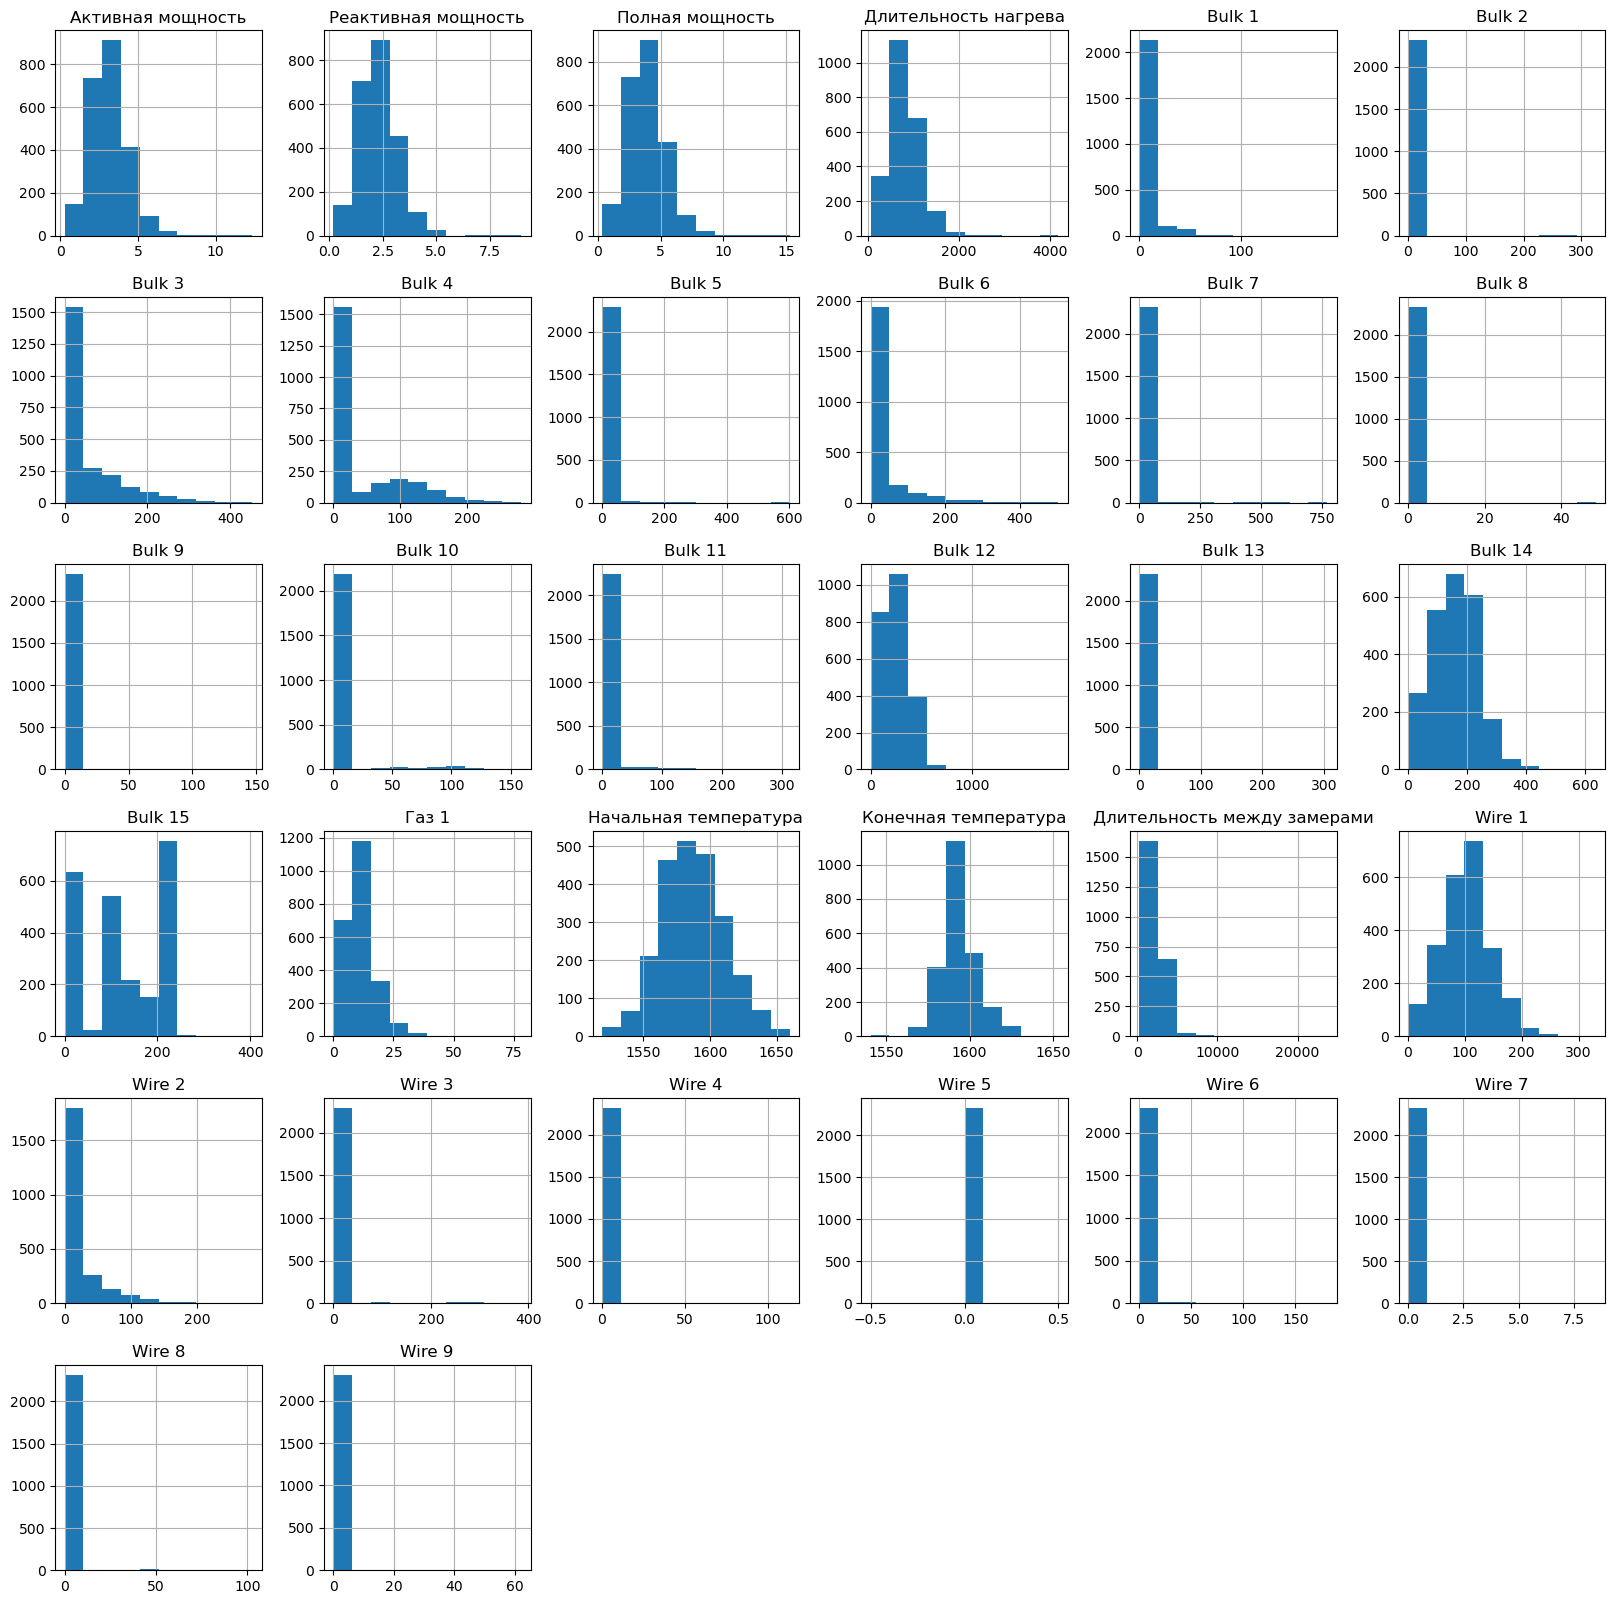

In [74]:
#построение гистограмм распределений для всех столбцов
df_full.hist(figsize=(20,20));

После предобработки можно отметить следующее:

* Активная, Реактивная, Полная мощности очевидно коррелируют друг с другом, распределние похоже на нормальное;
* Длительность нагрева, начальная, конечная температуры также имеют вид распределения, близкого к нормальному;
* Для веществ же распределения скорее индивидуальны, однако интересно отметить, что для Bulk 14 получено близкое к нормальному распределнию значений.

Можно рассмотреть зависимость Конечной температуры от Начальной:

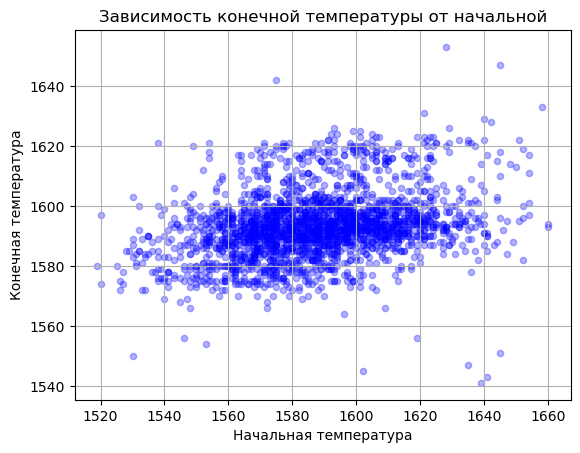

In [75]:
#построение графика зависимости
df_full.plot(x='Начальная температура', y='Конечная температура', kind='scatter',alpha=0.3, color='blue')
#добавление названия
plt.title('Зависимость конечной температуры от начальной')
#добавление сетки
plt.grid()
#вывод на экран
plt.show()

Интересно посмотреть на то насколько это некоррелирующая зависимость: возможно, это является косвенным признаком сложности технологического процесса с различными итерациями, множеством добавляемых материалов и тд.

Рассмотрим зависимость Конечной температуры от длительности нагрева:

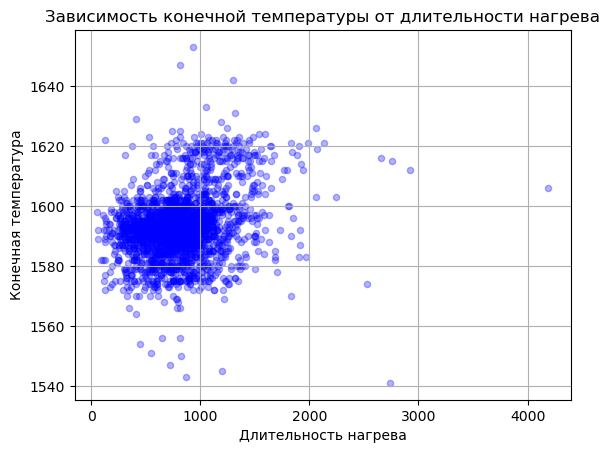

In [76]:
#построение графика зависимости
df_full.plot(x='Длительность нагрева', y='Конечная температура', kind='scatter',alpha=0.3, color='blue')
#добавление названия
plt.title('Зависимость конечной температуры от длительности нагрева')
#добавление сетки
plt.grid()
#вывод на экран
plt.show()

Интересный момент также заключается в том, что хоть и значения зависимости довольно скученные, говорить о явной пропорции "чем длиннее нагреваем тем выше температура" нельзя, что опять же говорит о сложности технологического процесса.

### Корреляционный анализ

Теперь посмотрим на корреляцию величин между собой:

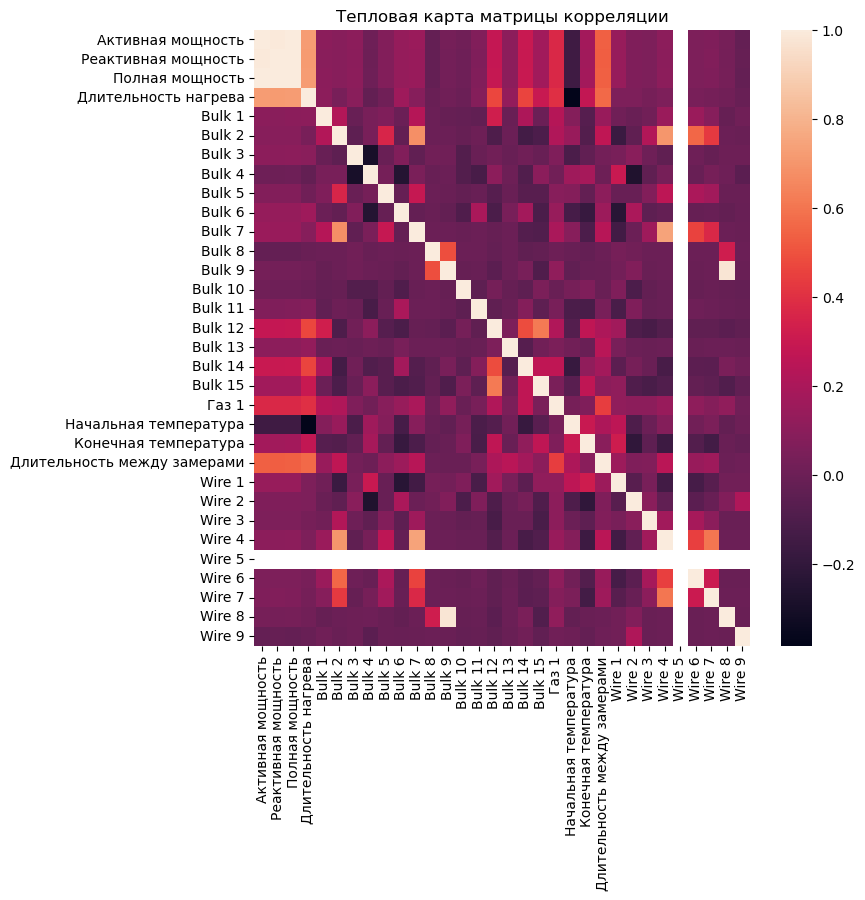

In [77]:
fig, ax=plt.subplots(figsize=(8,8))
sns.heatmap(df_full.corr())
plt.title('Тепловая карта матрицы корреляции')
plt.show()

Комментарий: из очевидного, что коррелируют мощности между собой. Также Длительность нагрева имеет значительный коэффициент корреляции с электроэнергией.

Из неочевидного: существует корреляция между применением материалов Bulk 9 и Wire 8.

В целом, остальные признаки друг с другом коррелируют не значительно, а некоторые значения коэффициентов уходят даже в небольшой минус.

Получается, что при проверке признаков на мультиколлинеарность можно отбросить Активную и Реактивную мощности - мы из них посчитали Полную, которая коррелирует с обоими значениями очень сильно. Попробуем избавиться от этих двух признаков и обучить модель без них.

Также можно удалить Wire 5: судя по выкладке describe(), это столбец сплошных нулей.

In [78]:
#удаление столбцов с высокой степенью корреляции
df_full=df_full.drop(columns=['Активная мощность','Реактивная мощность','Wire 5','Bulk 9'])

### Выводы

На основе анализа итоговых данных выяснено следующее:

* В данных отсутствуют пропуски и выбросы
* Мощности, длительность нагрева, начальная, конечная температуры, Bulk 14 имеют вид распределения, близкого к нормальному. В остальных случаях распределния более сложные;
* Зависимость конечной температуры от начальной неоднородная, хотя и есть склонность к линейности: возможно, это свидетельство сложности итерационного технологического процесса;
* Исследование на мультиколлинеарность показало, что активная, реактивная и полная мощности сильно коллинеарны (логично, ведь полная рассчитывается из двух этих составляющих), вследствие чего активная и реактивная мощности исключены из итогового датасета.

## Построение модели машинного обучения

По условиям задачи вынесены следующие требования:
* Соотношение обучающей и тестовой выборки равно 75:25
* Требование по метрике: МАЕ<=6.8
* Random_state=280823
* Минимум 3 модели
* Подбор гиперпараметров хотя бы у одной модели
* Выбор лучшей модели на кросс-валидации
* Проверка качества лучшей модели на тестовой выборке
* Анализ важности факторов

### Разделение данных на обучающую и тестовую выборки

In [79]:
#задаём константу для Random_state
RS=280823

In [80]:
#задаём признаки и целевой признак
features=df_full.drop(columns=['Конечная температура'])
target=df_full['Конечная температура']

In [81]:
#разделение выборок инструментом train_test_split
features_train, features_test,target_train,target_test=train_test_split(features,target,train_size=0.75, random_state=RS)

### Масштабирование данных

Данные в основном принадлежат схожим порядкам величин, но есть выделяющиеся (например, значения полной мощности в десятки раз меньше чем значения для некоторых добавляемых материалов), поэтому есть смысл отмасштабировать признаки.

In [82]:
#обучение инструмента масштабирования
scaler=StandardScaler()
scaler.fit(features_train)

#масштабирование численных признаков (у нас - всех)
features_train=scaler.transform(features_train)
features_test=scaler.transform(features_test)

### Обучение модели линейной регрессии

Ниже все модели будут проходить через GridSearchCV для кросс валидации и с перебором гиперпараметров на градиентном бустинге.

In [83]:
%%time
parametres={}
model=LinearRegression()
best_model_0=GridSearchCV(model,parametres,cv=6,scoring='neg_mean_absolute_error')
best_model_0.fit(features_train,target_train)

print(best_model_0.best_params_)
print(abs(best_model_0.best_score_))

{}
5.963826384508541
CPU times: total: 1 s
Wall time: 634 ms


### Обучение модели случайного леса

In [84]:
%%time

parametres={}
model=RandomForestRegressor(random_state=RS)
best_model_1=GridSearchCV(model,parametres,cv=6,scoring='neg_mean_absolute_error')
best_model_1.fit(features_train,target_train)

print(best_model_1.best_params_)
print(abs(best_model_1.best_score_))

{}
6.107525773195875
CPU times: total: 30 s
Wall time: 33.8 s


### Обучение модели градиентного бустинга lightgbm

In [85]:
%%time

parametres={'n_estimators': [  5,20 ],
     'learning_rate':[  0.05, 0.1 ]}
model=LGBMRegressor(random_state=RS)
best_model_2=GridSearchCV(model,parametres,cv=2,scoring='neg_mean_absolute_error')
best_model_2.fit(features_train,target_train)

print(best_model_2.best_params_)
print(abs(best_model_2.best_score_))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002425 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2013
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 16
[LightGBM] [Info] Start training from score 1593.209622
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2035
[LightGBM] [Info] Number of data points in the train set: 873, number of used features: 16
[LightGBM] [Info] Start training from score 1593.924399
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

### Обучение модели градиентного бустинга catboost

In [86]:
%%time

parametres={'iterations': [400,500],
           'learning_rate':[0.02,0.05]}

model=CatBoostRegressor(random_state=RS,silent=True)
best_model_3=GridSearchCV(model,parametres,cv=6,scoring='neg_mean_absolute_error')
best_model_3.fit(features_train,target_train)

print(best_model_3.best_params_)
print(abs(best_model_3.best_score_))

{'iterations': 400, 'learning_rate': 0.05}
5.8366353518465255
CPU times: total: 4min 21s
Wall time: 2min


### Константная модель

In [87]:
#создадим предсказания по медианному значению целевого показателя
predicted_train_const =pd.Series(target_train.median(),index=target_train.index)
#расчет MAE костантной модели
mean_absolute_error(predicted_train_const,target_train)

7.9965635738831615

### Выбор лучшей модели

Вывод сравнительной таблицы с результатами моделей:

| Модель             | MAE      |
|--------------------|----------|
| Линейная регрессия | 5.96     |
| Случайный лес      | 6.11     | 
| LightGBM           | 6.2      | 
| CatBoost           | 5.84     | 
| Константная модель | 8.00     | 

Отсюда можно утверждать, что лучше всех на тренировочной выборке себя показала модель градиентного бустинга CatBoost. Однако, стоит отметить также, что результаты всех моделей отличаются незначительно, особенно если сравнивать с констатной моделью, построенной по медиане.

### Тестирование лучшей модели

In [88]:
#расчёт метрики MAE для лучшей модели на тестовой выборке
mean_absolute_error(best_model_3.best_estimator_.predict(features_test),target_test)

5.681520155066177

Результат MAE, равный 5.68 <= 6.8. Следовательно, данную модель можно использовать в работе.

### Анализ важности факторов

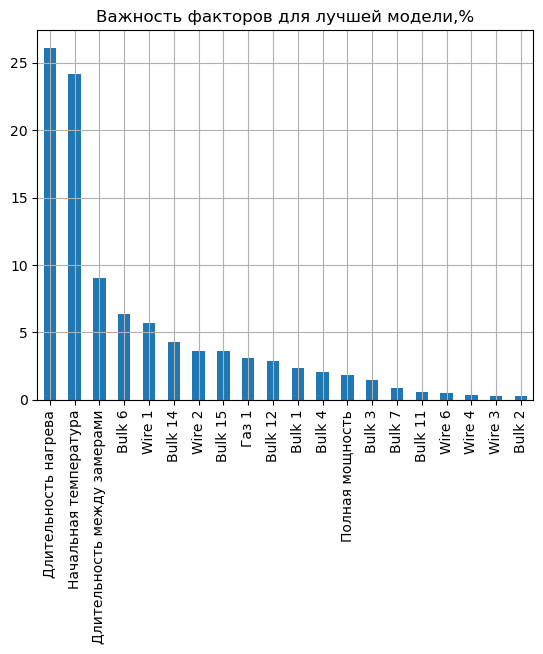

In [89]:
feat_importances = pd.Series(best_model_3.best_estimator_.feature_importances_, index=features.columns)
feat_importances.nlargest(20).plot(kind='bar')
plt.title('Важность факторов для лучшей модели,%')
plt.grid()
plt.show()

Из анализа важности факторов для лучшей модели наблюдается следующая тенденция: закономерно в лидерах длительность нагрева и начальная температура. Также Длительность между замерами вносит значительный вклад. Однако, что интересно, полная потреблённая мощность электроэнергии вносит свой вклад лишь на 3% для модели, и находится не в лидерах, даже сравнивая с некоторыми материалами и использованием газа для перемешивания.

### Общий вывод

В ходе работы была выполнена предобработка, добавление признаков, объединение, исследование мультиколлинеарности и обучение четырёх моделей: линейной регрессии, случайного леса, градиентного бустинга (двух типов: LightGBM и CatBoost). 

Среди дополнительных признаков были созданы полная мощность и длительность нагрева.

Модели LightGBM и CatBoost проходили перебор гиперпараметров инструментом GridSearchCV и с использованием кросс-валидации, модели линейной регрессии и случайного леса - только кросс-валидацией.

Основной вывод: все модели прошли требование на тренировочной выборке к MAE<6.8 и имеют небольшой разброс в результатах (от 6.12 до 5.84), что может говорить о применимости каждой из них для решения поставленной задачи. При этом лидером оказалась модель CatBoost с параметрами iterations=400, learning_rate=0.05, которая на тестовой выборке показала MAE=5.69.

Интересный вывод дало исследование важности факторов, влияющих на качество предсказаний модели CatBoost: основными двумя по важности были Длительность нагрева (27%) и Начальная температура (23%), тогда как Полная мощность оказалась ближе к середине с важностью в 3%.


# Отчёт

Ниже будут даны ответы на вопросы:

* Какие пункты плана были выполнены, а какие — нет. Почему?
* Какие трудности возникли и как вы их преодолели?
* Какие ключевые шаги в решении задачи вы выделили?
* Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?
* Список признаков, используемых для обучения лучшей модели и описание их предобработки
* Рекомендации по улучшению модели, решения

**Какие пункты плана были выполнены, а какие — нет. Почему?** 

Ниже представлен план проекта с необходимыми комментариями

## План проекта

| Пункт плана                                                  | Выполнено? | Комментарий                               |
|--------------------------------------------------------------|------------|-------------------------------------------|
|**1. Проведение обзора данных (EDA)**                         | ||
|**Подготовка и анализ исходных данных:**                      | |
| Импорт необходимых библиотек                                 |✓|
| Загрузка данных|✓|Загрузка выполнена через try-except для запуска с разными источниками|
| Получение общей информации о таблицах (head, info, describe)|✓||
| Корректировка наименований столбцов (при необходимости)|X|Названия столбцов не содержат неверных обозначений. Приведение к Snake case не производилось из-за однородности всех названий по всем таблицам|
| Графическое представление данных из таблиц|✓|Приведены гистограммы по всем столбцам с рассмотрением аномалий и характеров распределений|
| Проверка данных на аномалии|✓|Произведена проверка, найдены аномально низкие значения температур (ок. 1200) и отрицательной реактивной мощности. Позже по согласованию Заказчиком, эти аномалии удалены|
| Выводы|✓|Приведены выводы и вопросы для консультации с Заказчиком|
|**Предобработка данных:**| |
| Корректировка типов данных (при необходимости)|✓| Выполнены преобразования типа object на datetime во всех таблицах|
| Заполнение пропусков|✓| В данных по материалам Nan заменены на 0|
| Удаление дубликатов (при наличии)| X| Совершена проверка на явные дубликаты и качественная оценка наличия неявных дубликатов. Дубликатов не обнаружено|
| Удаление выбросов | ✓| Удалены согласованные Заказчиком выбросы|
| Выделение признаков и таргета | ✓|Выделен таргет - конечная температура, добавлены признаки: полная мощность, длительность нагрева, длительность между замерами(суммарное время нахождения материала в ковше). Время добавления сыпучих и проволочных материалов не учитывается в модели. Также не учитываются в модели ковши только с одним измерением температуры|
| Соединение таблиц| ✓| Произведено объединение необходимых таблиц по номеру ковша|
| Выводы| ✓|Приведены выводы по итоговой таблице с данными|
| **Исследование итоговой таблицы с данными:**| |
| Аналитический анализ| ✓| Произведён анализ итоговых данных на пропуски, выбросы, средние значения и экстремумы.|
| Графический анализ| ✓|Произведён анализ гистограмм распределений итоговых данных, а также рассмотрены зависимости Конечная температура - Начальная температура, Конечная температура - длительность нагрева|
| Корреляционный анализ|✓ |Произведён анализ на мультиколлинеарность и отброшены признаки, сильно коррелирующие друг сдругом (>0.9): активная, реактивная мощности, wire 5, bulk 9|
| Выводы| ✓|Основной вывод заключается в том, что описываемый технологический процесс - сложный, итерационный, и что для прогнозирования конечной температуры нужно большое количество данных (это есть) и внимательный подход к подготовке, анализу данных и создании моделей машинного обучения|
|**2. Построение модели машинного обучения**| |
|**Обучение модели:**| |
| Разделение данных на обучающую и тестовую выборки|✓ |Выполнено разделение на обучающую и тестовую выборки в соотношении 75:25|
| Масштабирование данных|✓ |Произведено масштабирование данных в силу их неоднородности|
| Обучение модели линейной регрессии| ✓|Обучена модель кросс-валидацией. Результат MAE на тренировочной выборке 5.96|
| Обучение модели случайного леса| ✓|Обучена модель с кросс-валидацией. Результат MAE на тренировочной выборке 6.11|
| Обучение модели градиентного бустинга lightgbm| ✓|Обучена модель с кросс-валидацией и перебором гиперпараметров. Результат MAE на тренировочной выборке 6.2|
| Обучение модели градиентного бустинга catboost| ✓|Обучена модель с кросс-валидацией и перебором гиперпараметров. Результат MAE на тренировочной выборке 5.84|
| Константная модель|✓ |Выведена констатная модель по медиане. Результат MAE на тренировочной выборке 8.00| 
| Выбор лучшей модели|✓ | Выбрана лучшая модель с лучшими гипер-параметрами - градиентный бустинг CatBoost|
|**Проверка моделей:**| |
| Тестирование лучшей модели на тестовой выборке| ✓| CatBoost показала результат MAE=5.68|
| Если MAE на тестовых данных > 6.8 - доработка модели| X|В этом необходимости не было|
| Анализ важности факторов| ✓| Интересное наблюдение: наиболее важные факторы: длительность нагрева, начальная температура, длительность между замерами. При этом траты электроэнергии как фактор для модели находятся в середине и имеют вес в 3%"|
|**3. Общий вывод**||

**Какие трудности возникли и как вы их преодолели?** 

Основная трудность была в постановке задачи и выборе целевой. Решено было перебором вариантов и консультацией с тимлидом. 

Также было узкое место по выбору параметров features: основываясь на логику и примерное понимание сути моделируемого физического процесса надо было добавить дополнительные параметры, которые в итоге улучшили качество предсказаний.

**Какие ключевые шаги в решении задачи вы выделили?** 

Наиболее точно см. план, но в целом ключевые шаги выделены следующие:

* Рассмотрены исходные данные с целью ознакомления и проверка на наличие аномалий, выбросов;
* Проивзедён опрос Заказчика по уточнению целей, задач и нюансов в распознавании данных;
* Произведена предобработка данных с целью дальнейшего наилучшего подбора модели;
* Произведено объединение данных из различных таблиц;
* Произведён анализ очищенных данных, исследованы корреляции признаков;
* Разделены признаки на тренировочные и целевой (при необходимости добавлены новые признаки);
* Разделены выборки на тренировочную и тестовую;
* Произведён подбор нескольких моделей машинного обучения с перебором гиперпараметров на кросс-валидации;
* Отобрана лучшая модель на кросс-валидации по параметрам качества предсказаний;
* Проверена лучшая модель на тестовой выборке;
* Составлен отчёт о проделанной работе и рекомендациях бизнесу по применению модели.


**Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?** 

* Итоговая модель - градиентный бустинг CatBoost.

* Гиперпараметры из тех, что перебирались инструментом GridSearchCV: 'iterations': 400, 'learning_rate': 0.05.

* Качество MAE на тестовой выборке: 5.68

* Random state = 280823

**Список признаков, используемых для обучения лучшей модели и описание их предобработки** 

|Признак|Предобработка|
|-------|-------------|
|Полная мощность|Выведена из активной и реактивной мощностей. В реактивной мощности был удалён выброс - отрицательное значение, в сотни раз больше среднего|
|Длительность нагрева|Выведена из таблицы с электрическими мощностями как разность окончания нагрева последней итерации и начала нагрева начальной для каждого ковша|
|Bulk 1...Bulk 8, Bulk 10...Bulk 15|Заполнены пропуски: заменены NaN на 0|
|Газ 1|Предобработка не производилас|
|Начальная температура|Выведена из таблицы с замерами температур для каждого ковша|
|Длительность между замерами|Выведена из таблицы с замперами температур по каждому ковшу как разность между последним замером и первым|
|Wire 1...Wire 4, Wire 6...Wire 9|Заполнены пропуски: заменены NaN на 0|
       

**Рекомендации по улучшению модели, решения** 

Основные рекомендации по улучшению модели:

Можно добавить побольше признаков, например: 
* выход температуры за некоторое пороговоре значение. 1- вышел, 0 - нет. Смотрим на те температуры, что вышли и проводим как анализ данных, что могло привести к этому, так и включаем в модель и по ходу реального процесса в дальнейшем говорим оператору: ты рискуешь перегреть ковш через 3 итерации и растратить кучу денег, отнесись к ним внимательно;
* добавить в модель как признак время добавления материалов от начала процесса: тогда возможно и показания будут точнее, и модель сможет предсказывать если какую-то важную примесь положили не столько сколько нужно было
* добавить в модель какую-то экономику, стоимость электроэнергии: тогда в процессе производства будет прогностически видно, сколько стоит данный ковш и, возможно, как-то повлиять на технологию, или вообще отменить и отправить его в переработку, если процесс стал вдруг нерентабелен 
* добавить номера смен/время суток в качестве признака - маловероятно, но может и помочь увеличить точность и обратить внимание персонала на то, как он выполняет свои обязанности

Для решения в целом, есть основное наверное требование: совместить нашу модель с другими, которые учитывают **химический состав на входе и выходе например**. 

Также можно исследовать энергоэффективность производственного процесса по вторичным признакам, например (сейчас, не зная специфики точно, могу ошибаться, но если сравнивать с иными производствами, то может и сработать):
* исторические данные об авариях, можно определить пороги в технологическом процессе, которые нельзя переходить, и предсказывать потенциальное приближение к таковым через несколько итераций;
* вибрация основных механизмов
* нагрев изоляции, наиболее слабых мест технологической установки
* если есть какое-то регулярно меняемое оборудование или материалы - дата их замены (изоляция или например подшипники насоса или что-то такое)
* условия труда на рабочих местах (может влиять скорее не на качество металла, а на прочие расходы Предприятия на охрану труда, страховки, менеджмент качества и сторонний аудит)

